In [5]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import random

# Threshold values from the table in the paper
P_t = [7, 8, 9, 10, 12, 14, 16, 18, 20, 22]
O_t = [20, 22, 24, 26, 28, 30, 32, 34, 36, 38]
MAX_DISTANCE = 10

def Mean_Color(window):
    non_damaged = window[window != 0]
    if non_damaged.size == 0:
        return np.array([0, 0, 0])  # Return black if no non-damaged pixels
    return np.mean(non_damaged, axis=0)


def Useful_Info(window):
    non_damaged = np.count_nonzero(window != 0)
    total = window.size
    if total == 0:
        return 0
    return (non_damaged / total) * 100

def Noise_Info(window):
    damaged = np.count_nonzero(window == 0)
    total = window.size
    if total == 0:
        return 0
    return (damaged / total) * 100

def Weighted_Mean_Color(window, weights):
    non_damaged = window[window[..., 0] != 0]
    if non_damaged.size == 0:
        return np.array([0, 0, 0])
    weighted_sum = np.sum(non_damaged * weights[..., np.newaxis], axis=0)
    total_weight = np.sum(weights)
    if total_weight != 0:
        return weighted_sum / total_weight
    else:
        return np.array([0, 0, 0])

def Global_Mean_Color(image):
    non_damaged = image[image != 0].reshape(-1, image.shape[-1])
    if non_damaged.size == 0:
        return np.array([0, 0, 0])
    return np.mean(non_damaged, axis=0)

def Get_Window(image, x, y, DIS):
    height, width, _ = image.shape
    x_min = max(0, x - DIS)
    x_max = min(width, x + DIS + 1)
    y_min = max(0, y - DIS)
    y_max = min(height, y + DIS + 1)
    return image[y_min:y_max, x_min:x_max]

def Inpaint_improved(image, damaged_pixels):
    inpainted_image = image.copy()
    height, width, _ = image.shape

    for y, x in damaged_pixels:
        DIS = 1
        window = Get_Window(inpainted_image, x, y, DIS)
        P = Useful_Info(window)
        O = Noise_Info(window)

        while True:
            if DIS > MAX_DISTANCE:
                inpainted_image[y, x] = Global_Mean_Color(image)
                break
            elif P != 0:
                if P > P_t[DIS-1]:
                    weights = np.exp(-np.linspace(-DIS, DIS, 2*DIS+1)**2 / (2*(DIS/2)**2))
                    weights = np.outer(weights, weights)
                    weights_flat = weights.flatten()
                    valid_weights = weights_flat[window[..., 0].flatten() != 0]
                    inpainted_image[y, x] = Weighted_Mean_Color(window, valid_weights)
                    break
                else:
                    DIS += 1
                    window = Get_Window(inpainted_image, x, y, DIS)
                    P = Useful_Info(window)
                    O = Noise_Info(window)
            else:
                if O > O_t[DIS-1]:
                    DIS += 1
                    window = Get_Window(inpainted_image, x, y, DIS)
                    P = Useful_Info(window)
                    O = Noise_Info(window)
                else:
                    inpainted_image[y, x] = Global_Mean_Color(image)
                    break
    return inpainted_image


def Inpaint(image, damaged_pixels):
    inpainted_image = image.copy()
    for y, x in damaged_pixels:
        DIS = 1
        window = Get_Window(inpainted_image, x, y, DIS)
        P = Useful_Info(window)
        O = Noise_Info(window)
        while True:
            if DIS > MAX_DISTANCE:
                inpainted_image[y, x] = Global_Mean_Color(image)
                break
            elif P != 0:
                if P > P_t[DIS-1]:
                    inpainted_image[y, x] = Mean_Color(window)
                    break
                else:
                    DIS += 1
                    window = Get_Window(inpainted_image, x, y, DIS)
                    P = Useful_Info(window)
                    O = Noise_Info(window)
            else:
                if O > O_t[DIS-1]:
                    DIS += 1
                    window = Get_Window(inpainted_image, x, y, DIS)
                    P = Useful_Info(window)
                    O = Noise_Info(window)
                else:
                    inpainted_image[y, x] = Global_Mean_Color(image)
                    break
    return inpainted_image

def Detect_Damaged_Pixels(image):
    damaged_pixels = np.argwhere(np.all(image == [0, 0, 0], axis=-1))
    return damaged_pixels


def Simulate_Damage(image, num_lines=5):
    damaged_image = Image.fromarray(image)
    draw = ImageDraw.Draw(damaged_image)

    width, height = damaged_image.size
    for _ in range(num_lines):
        x1, y1 = random.randint(0, width - 1), random.randint(0, height - 1)
        x2, y2 = random.randint(0, width - 1), random.randint(0, height - 1)
        draw.line((x1, y1, x2, y2), fill=(0, 0, 0), width=3)
    
    return np.array(damaged_image)

original_image = np.array(Image.open('img1.jpg'))

damaged_image = Simulate_Damage(original_image, num_lines=15)

damaged_pixels = Detect_Damaged_Pixels(damaged_image)

inpainted_image = Inpaint(damaged_image, damaged_pixels)

inpainted_image_improved = Inpaint_improved(damaged_image, damaged_pixels)

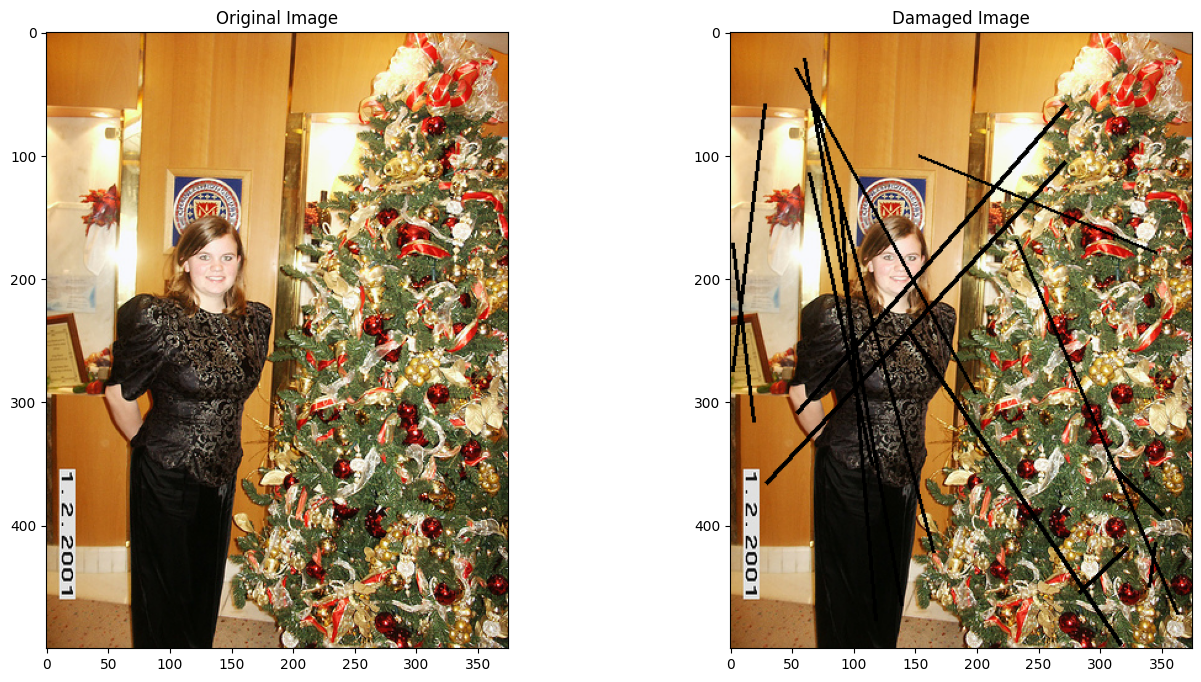

In [6]:
#results
plt.figure(figsize=(25, 8))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(original_image)

plt.subplot(1, 3, 2)
plt.title('Damaged Image')
plt.imshow(damaged_image)

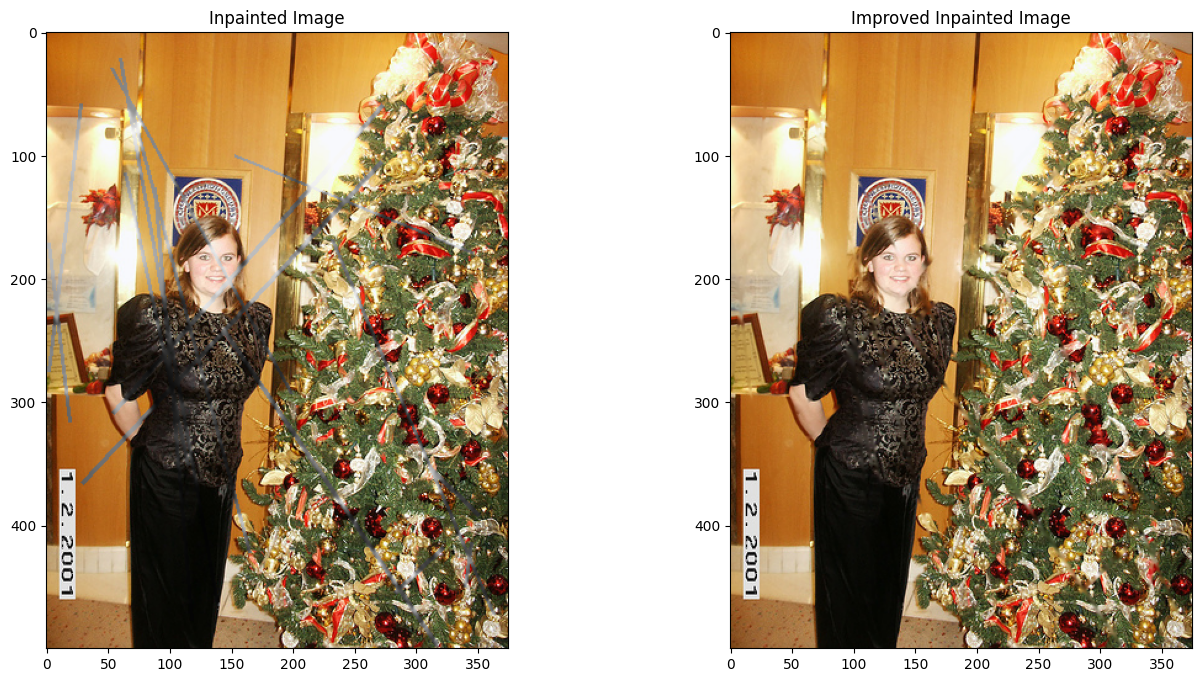

In [7]:
#results
plt.figure(figsize=(25, 8))

plt.subplot(1, 3, 1)
plt.title('Inpainted Image')
plt.imshow(inpainted_image)

plt.subplot(1, 3, 2)
plt.title('Improved Inpainted Image')
plt.imshow(inpainted_image_improved)